In [1]:
# using Logging
# Logging.disable_logging(LogLevel(3))
using Plots
using FFTW


(process:19668): GLib-GIO-WARNING **: 10:09:29.955: Unexpectedly, UWP app `draw.io.draw.ioDiagrams_16.5.1.0_x64__1zh33159kp73c' (AUMId `draw.io.draw.ioDiagrams_1zh33159kp73c!draw.io.draw.ioDiagrams') supports 2 extensions but has no verbs


In [7]:
# Solves i∂t = -Δ/2 ψ + Vψ starting at ψ for a time t, with timestep Δt.
function propagate(ψ, t, Vx, kinetic, Δt)
    n = ceil(Int, real(t/Δt))
    Δt = t/n
    for i = 1:n
        ψ = step(ψ, Δt, Vx, kinetic)
    end
    ψ
end

# Perform a step of a splitting method (Trotter formula)
function step(ψ, Δt, Vx, kinetic)
    # Propagate V
    ψ = @. ψ * exp(-im*Δt/2*Vx)
    # transform to momentum space
    ψf = fft(ψ)
    # Propagate -Δ/2
    @. ψf *= exp(-im*Δt/2*kinetic)
    # transform back to real space
    ψ = ifft(ψf)
end

# Grid from -L to L with N points
function dynamics(ψ0_fun, V_fun; L=10, N=1000, T=4*im, Δt=0.01*im, frames=100, tanim=6)
    x = range(-L, L, length=N)

    # The FFT formula is X[k] = sum_n=0^N-1 X[n] e^-2πikn/N. We want 2π k n / N to be equal to ω[k] x[n], so ω[k] = 2π k n / N x[n].
    # x[n] = n/N so ω[k] = 2π k, for k = 0...N-1
    ωs = 0:N-1
    wraparound(i) = (i <= div(N+1,2)+1) ? ωs[i] : -ωs[end-i+2] # last element is ωs[2], the first non-DC component
    momentum = 2π/(2L)*collect(wraparound.(1:N))
    kinetic = (momentum .^ 2) / 2

    Vx = V_fun.(x)
    ψ0 = ψ0_fun.(x)
    ψ = ψ0

    ψ0max = maximum(abs.(ψ0))
    ylim = [-2*ψ0max, 2*ψ0max]

    anim = @animate for n = 1:frames
        # println("Frame $n/$frames")
        t_before = T*(n-1)/frames
        t_after = T*n/frames
        ψ = propagate(ψ, t_after - t_before, Vx, kinetic, Δt)
        plot(x, [real(ψ), imag(ψ), abs.(ψ), Vx], ylim=ylim, grid=false, w=[1 1 2 1], color = ["red" "blue" "black" "grey"], linestyle=[:solid :solid :solid :dash], label=["Real" "Imag" "Modulus" "Pot"])
    end

    fps = frames/tanim
    gif(anim, fps=fps)
end;

In the rest, we just call `dynamics` with different initial conditions and potentials. By default, this is on a grid with $1000$ points from $-10$ to $10$ with periodic boundary conditions.

In [8]:
V(x) = 1/2*x^2;

┌ Info: Saved animation to 
│   fn = C:\Users\matth\AppData\Local\Temp\jl_2lXWvC8Noi.gif
└ @ Plots C:\Users\matth\.julia\packages\Plots\rDbWY\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\matth\\AppData\\Local\\Temp\\jl_2lXWvC8Noi.gif")
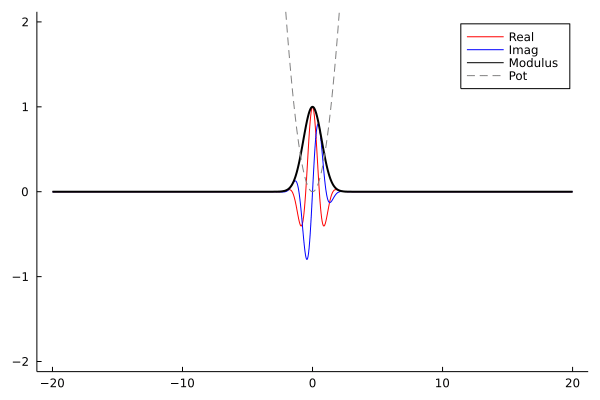

In [10]:
psi0(x) = exp(-x^2)*exp(3*im*x)
dynamics(psi0, V, L=20, T=16)

The solution here is $$\psi(x,t) = e^{-i E t} \psi(x,0).$$ The real and imaginary part oscillate, but the modulus (and any other observable) stays constant.

Let's make the wave packet move now: we keep its "perfectly balanced" variance, but give it an initial kick.

### Reprise du code en temps imaginaire

In [11]:
N = 10;
ωs = 0:N-1
wraparound(i) = (i <= div(N+1,2)+1) ? ωs[i] : -ωs[end-i+2] # last element is ωs[2], the first non-DC component

wraparound (generic function with 1 method)

In [13]:
L = 10;
momentum = 2π/(2L)*collect(wraparound.(1:N))
kinetic = (momentum .^ 2) / 2

10-element Vector{Float64}:
 0.0
 0.04934802200544679
 0.19739208802178715
 0.4441321980490211
 0.7895683520871486
 1.2337005501361697
 0.7895683520871486
 0.4441321980490211
 0.19739208802178715
 0.04934802200544679

In [ ]:
x = range(-L, L, length=N);
psi0(x) = exp(-x^2)*exp(3*im*x);
V(x) = 1/2*x^2;
Vx = V_fun.(x);
ψ0 = ψ0_fun.(x);